<a href="https://colab.research.google.com/github/cisimon7/Non-Contact-Measurement-of-Cable-Profile/blob/main/main/Computer_Vision_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Non-Contact Measurement of Cable Profile
To measure sagging and other properties of the cable using images of the cable so as to improve Robot Positioning Accuracy

<b>Goal of this project</b>
<ol>
<li>Repeatability: Measurement of positioning while attaining a particular pose multiple times</li>
<li>Directional Accuracy: Accuracy in different positions of the end effector in it's workspace</li>
</ol>

##### <b><i>Linking notebooks</i></b>

In [1]:
from IPython.display import clear_output
!pip install kora -q
from kora import drive
drive.link_nbs()

# import Aruco_Helpers
from Simulation import Simulation
from IPython.display import clear_output 
from Catenary_Predictor import CatenaryPredictor

clear_output()

##### <b><i>Imports</i></b>

In [2]:
import cv2
import os
import sys
import numpy as np
from cv2 import aruco
from matplotlib import pyplot as plt
import torch

##### <b><i>Downloading Dataset</i></b>

In [3]:
!git clone https://github.com/RABKKK/CableDrivenRobotCableModel.git
clear_output()

##### <b><i>Utilities Functions</i></b>

In [4]:
 def read_and_resize_image(filename, grayscale = False, fx= 0.5, fy=0.5):
    if grayscale:
      img_result = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
      imgbgr = cv2.imread(filename, cv2.IMREAD_COLOR)
      img_result = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
    img_result = cv2.resize(img_result, None, fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC)
    return img_result
  
def showInRow(list_of_images, titles = None, disable_ticks = False):
  plt.rcParams["figure.figsize"] = (16, 10) # (w, h)
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
  plt.show()

##### <b><i>Testing on a single Frame</i></b>

In [5]:
# Get Video
video_example1 = "/content/CableDrivenRobotCableModel/baumer_video0048.avi"
video_example2 = "/content/CableDrivenRobotCableModel/baumer_video0043.avi"

# Open video with cv2
cap = cv2.VideoCapture(video_example2)
ret, frame = cap.read()           
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

In [6]:
# Function to filter detected fiduciary markers in the image
def is_not_ok(image):

  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  dst = cv2.cornerHarris(image,2,3,0.04)

  if (len(dst)>10  and len(image[image<20])>100) : return False 

  return True

In [20]:
# Currently hardcoded here. Will be replaced with function to get the values from a .yml file
camera_matrix = np.array(
    [[2.1421339441621294e+03, 0., 1.0023255121210714e+03],
     [0., 2.1454671231983511e+03, 5.8194689020159205e+02],
     [0., 0., 1.]], dtype=np.float32)
dist_coefs = np.array(
    [ -1.9775652701574477e-02, -7.4457910153644252e-02, 7.3270012061200864e-04, 3.2844589119313313e-03, 1.2552634421460869e+00],
    dtype=np.float32).transpose()

In [8]:
idx     = []  # Corners rejected idexes
centers = []  # Centre of accepted markers

Detetction of AruCo markers without filtering

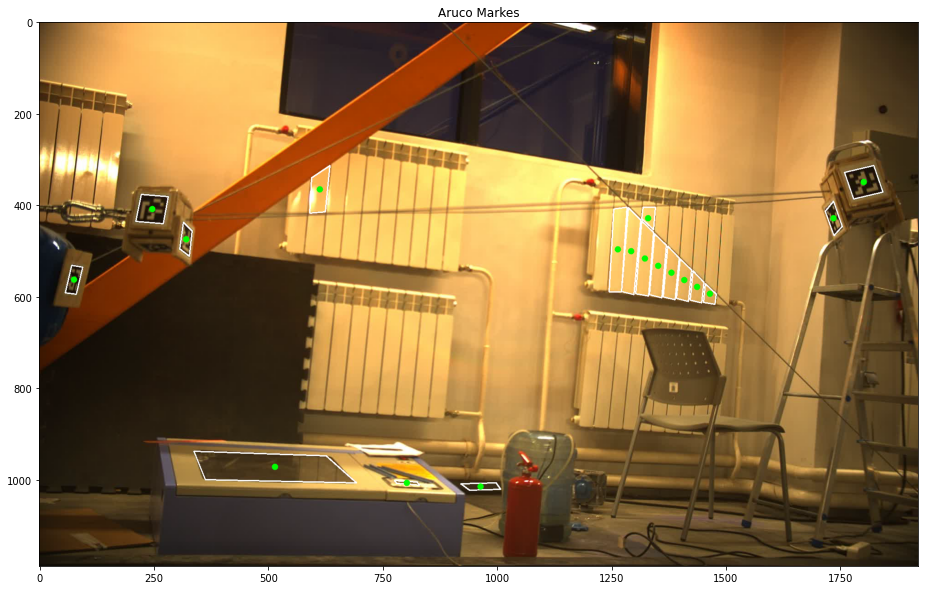

In [13]:
frame_copy = frame.copy()

aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_250)
aruco_params = cv2.aruco.DetectorParameters_create()
(corners, ids, rejected) = cv2.aruco.detectMarkers(frame_copy, aruco_dict, parameters=aruco_params)


for i,markerCorner in enumerate(rejected):

  corners = markerCorner.reshape((4, 2))
  (topLeft, topRight, bottomRight, bottomLeft) = corners.astype(int)

  topRight = (topRight[0], topRight[1])
  bottomRight = (bottomRight[0], bottomRight[1])
  bottomLeft = (bottomLeft[0], bottomLeft[1])
  topLeft = (topLeft[0], topLeft[1])

  x1 = min(topLeft[0], bottomLeft[0])
  x2 = max(topRight[0], bottomRight[0])
  y1 = max(topRight[1], topRight[1])
  y2 = min(bottomRight[1], bottomLeft[1])

  x1, x2 = np.sort([x1,x2])
  y1, y2 = np.sort([y1,y2])

  # draw the bounding box of the ArUCo detection
  cv2.line(frame_copy, topLeft, topRight, (255, 255, 255), 2)
  cv2.line(frame_copy, topRight, bottomRight, (255, 255, 255), 2)
  cv2.line(frame_copy, bottomRight, bottomLeft, (255, 255, 255), 2)
  cv2.line(frame_copy, bottomLeft, topLeft, (255, 255, 255), 2)

  cx = int((topLeft[0] + bottomRight[0]) / 2.0)
  cy = int((topLeft[1] + bottomRight[1]) / 2.0)
  cv2.circle(frame_copy, (cx, cy), 7, (0, 255, 0), -1)
  centers.append([cx, cy])

showInRow([frame_copy], ["Aruco Markes"])

Detetction of AruCo markers applying filtering and Corresponding Axis Drawn

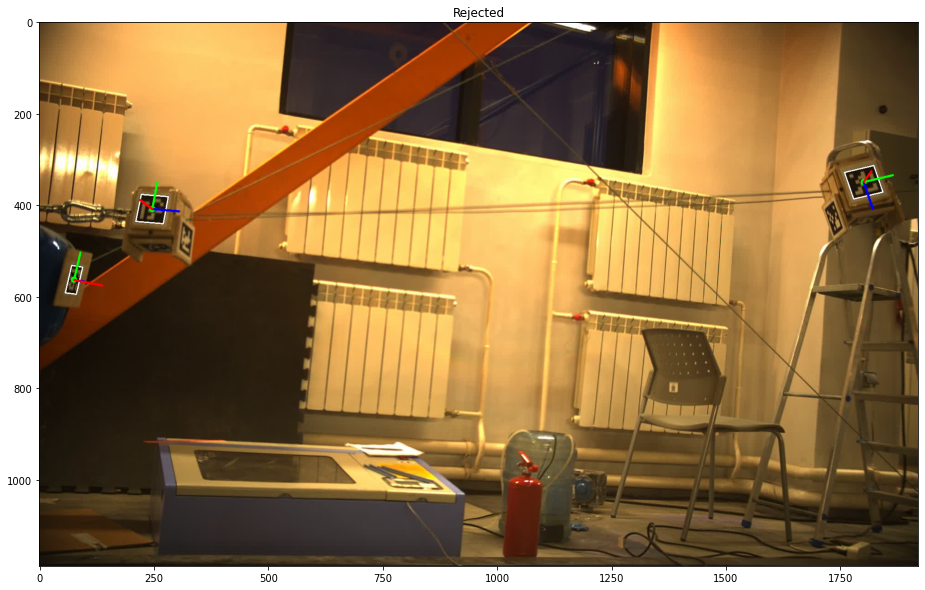

In [22]:
frame_copy = frame.copy()

arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_250)
arucoParams = cv2.aruco.DetectorParameters_create()
(corners, ids, rejected) = cv2.aruco.detectMarkers(frame_copy, aruco_dict, 
                                                   parameters=aruco_params,
                                                   cameraMatrix=cameraMatrix,
                                                   distCoeff=distcoef)
for i,markerCorner in enumerate(rejected):

  corners = markerCorner.reshape((4, 2))
  (topLeft, topRight, bottomRight, bottomLeft) = corners.astype(int)

  topRight = (topRight[0], topRight[1])
  bottomRight = (bottomRight[0], bottomRight[1])
  bottomLeft = (bottomLeft[0], bottomLeft[1])
  topLeft = (topLeft[0], topLeft[1])

  x1 = min(topLeft[0], bottomLeft[0])
  x2 = max(topRight[0], bottomRight[0])
  y1 = max(topRight[1], topRight[1])
  y2 = min(bottomRight[1], bottomLeft[1])

  x1, x2 = np.sort([x1,x2])
  y1, y2 = np.sort([y1,y2])

  if is_not_ok(frame[y1:y2, x1:x2, : ]): 
    idx.append(i)
    continue

  # draw the bounding box of the ArUCo detection
  cv2.line(frame_copy, topLeft, topRight, (255, 255, 255), 2)
  cv2.line(frame_copy, topRight, bottomRight, (255, 255, 255), 2)
  cv2.line(frame_copy, bottomRight, bottomLeft, (255, 255, 255), 2)
  cv2.line(frame_copy, bottomLeft, topLeft, (255, 255, 255), 2)

  cx = int((topLeft[0] + bottomRight[0]) / 2.0)
  cy = int((topLeft[1] + bottomRight[1]) / 2.0)
  cv2.circle(frame_copy, (cx, cy), 7, (0, 255, 0), -1)
  centers.append([cx, cy])

rvec, tvec, _ = aruco.estimatePoseSingleMarkers(np.array(rejected).astype(np.float64), 0.05, camera_matrix, dist_coefs)
for i in range(len(tvec)):
  if (i in idx): continue 
  aruco.drawAxis(frame_copy, cameraMatrix, distcoef, rvec[i], tvec[i], 0.05)

showInRow([frame_copy], ["Rejected"])

Selection of Cable in the image

In [ ]:
low_box = np.genfromtxt('AxisCentreBlock1.csv', delimiter=' ')
high_box = np.genfromtxt('AxisCentreBlock2.csv', delimiter=' ')

In [ ]:
def get_2d_from_3d(vector_3d, camera_matrix):
    d2 = np.abs(vector_3d @ camera_matrix)  # Camera matrix * vector_3d
    return int(d2[0] / d2[-1]), int(d2[1] / d2[-1])

In [ ]:
frame_copy1 = frame_copy.copy()

center1 = centers[0] # low_box[0]*100
center2 = centers[1] # high_box[0]*100


# Getting 3D position for x, y of the lower and x2,y2 of the upper boxes
x1, y1 = center1 #get_2d_from_3d(center1, cameraMatrix)
x2, y2 = center2 #get_2d_from_3d(center2, cameraMatrix)

print([x1, y1])
print([x2, y2])


# Draw their location
cv2.circle(frame_copy1,(x1,y1), 10, [0,0,255], cv2.FILLED)
cv2.circle(frame_copy1, (x2,y2), 10, [0,0,255], cv2.FILLED)


# Middle point
mid = np.asarray(center1)*0.5 + 0.5*np.asarray(center2)   

# Draw the middle point
cv2.circle(frame_copy1, mid, 15, [255,0,0], cv2.FILLED)


# We can draw the rest of the line
# f = lambda t: center2+t*(center1-center2)
# for i in np.arange(-10, 100, step=0.005):
#     res = f(i)
#     frame_copy1 = cv2.circle(frame_copy1, get_2d_from_3d(res, cameraMatrix), 1, [0,0,255], cv2.FILLED)

    
plt.figure(figsize=(20,10))
plt.imshow(frame_copy1)
plt.xticks([]), plt.yticks([])
plt.show()

[269, 823]
[186, 770]


SystemError: ignored

### References
<ul>
<li>Measurement of End-effector Pose Errors and the Cable Profile of Cable-Driven Robot using Monocular Camera by Riby A. Boby</li>
<li>Generating ArUco markers with OpenCV and Python
by Adrian Rosebrock: <a href="https://www.pyimagesearch.com/2020/12/14/generating-aruco-markers-with-opencv-and-python/">link</a></li>
<li>Detecting ArUco Markers with Opencv and python
by Adrian Rosebrock: <a href="https://www.pyimagesearch.com/2020/12/21/detecting-aruco-markers-with-opencv-and-python/">link</a></li>
<li>Detection of ArUco Markers from OpenCv website: <a href="https://docs.opencv.org/master/d5/dae/tutorial_aruco_detection.html">link</a></li>

<li>What is Camera Calibration by Mathworks: <a href="https://www.mathworks.com/help/vision/ug/camera-calibration.html">link</a></li>
<li><a href="https://github.com/qvviko/cv20_project">code link</a></li>
<li><a href="https://github.com/RABKKK/CableDrivenRobotCableModel.git">dataset link<a/></li>
</ul>

In [ ]:
# https://mecaruco2.readthedocs.io/en/latest/notebooks_rst/Aruco/aruco_basics.html